[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/royforestano/Deep_Learning_Symmetries/blob/main/symmetries_tutorial.ipynb)

# Deep Learning Symmetries and Their Lie Groups, Algebras, and Subalgebras from First Principles - Tutorial

Author: Roy Forestano

Date of Completion: 13 January 2023

Connected to the paper on: Deep Learning Symmetries and Their Lie Groups, Algebras, and Subalgebras from First Principles (arXiv:2301.05638: https://arxiv.org/abs/2301.05638)

In this notebook, I build a neural network which takes in a random state of matrices and structure constants and alters them to reproduce the generators and structure constants of a given non-abelian group [ here SO(3) ] with dimension $N$ given a data set of the same dimension. The model takes in an array of the desired number of generators $N_{g}$ as $N \times N$ matrices and an array of the structure constants with shape $N_{brackets} \times N_{g}$. One part of the model then loops over each of the generators applying a sequential layer to each. The second part is one sequential layer over the structure constant array. The model modifies these arrays to produce the desired generators and structure constants with an interconnected loss function between generators and structure constants to satisy the necessary conditions.

Aside: This notebook only computes the structure constants for $N < 6$ due to runtime issues. It will still run as desired for higher than five dimensions, but will only be finding the generators and not the structure constants. This model runs more efficiently with less epochs for lower dimensions, however, if you would like to scale the model to find the structure constants for higher dimesnions, construct a module list for the structure constants (as is being done for the generators) in the model, which will find the structure constants row by row rather than the entire matrix all at once. The number of epochs will need to be increased to arrive at the same loss, but fortunately, the model will run for large dimensions.

## Useful resources

1. Torch.norm: https://pytorch.org/docs/stable/generated/torch.norm.html
2. Rot in 4D: https://en.wikipedia.org/wiki/Rotations_in_4-dimensional_Euclidean_space
3. Matrix Norm: https://en.wikipedia.org/wiki/Matrix_norm
4. Stack lie: https://math.stackexchange.com/questions/1284164/structure-constants-for-and-the-adjoint-representation-and-meaning-in-sl2-f?rq=1
5. $L^2$ Norm: https://mathworld.wolfram.com/L2-Norm.html
6. Parameters: https://towardsdatascience.com/parameters-and-hyperparameters-aa609601a9ac
7. Another way to transpose, (tensor).T or torch.t(): https://pytorch.org/docs/stable/generated/torch.t.html
8. Complex Eigenvalues: https://math.stackexchange.com/questions/1546104/complex-eigenvalues-of-a-rotation-matrix

In [285]:
!pip install torch

## Imports

In [286]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import scipy
import os
import copy
from tqdm import tqdm
from time import time

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
torch.set_default_dtype(torch.float64)

In [287]:
plt.rcParams["font.family"] = 'sans-serif'
np.set_printoptions(formatter={'float_kind':'{:f}'.format}) 

## Fix Random State

In [288]:
np.random.seed(0)
torch.manual_seed(0)

## Choose dimensions

In [289]:
n       = 300 # sample size
n_dim   = 3   # dimension
n_gen   = 3   # n_gen_full = int(n_dim*(n_dim-1)/2) formula for full algebra

## Create Data

In [290]:
# Ceate n number of n-dim vectors
data    = torch.tensor(np.random.randn(n,n_dim))

In [291]:
data.shape

torch.Size([300, 3])

## Define the possible oracles, $\phi(x)$, to be used in the loss function

In [292]:
if n_dim==2:
    def oracle_squeeze(data):
        return (data[:,0]*data[:,1]).reshape(data.shape[0],1)
    
    def oracle_piecewise_linear(data):
        a = data[:,0]
        return np.where(a >= 0, a, -data[:,1])
    
    def oracle_manhattan(data):
        return torch.abs(data[:,0])+torch.abs(data[:,1])

def oracle_norm(data): # L^2 Norm (includes imaginary) on X: sqrt(sum(|x_i|^2))
    return torch.norm(data,dim=1)
                
if n_dim==4:
    def oracle_lorentz(data):
        return (data[:,0].reshape(data.shape[0],1))**2 \
                - (data[:,1].reshape(data.shape[0],1))**2 \
                - (data[:,2].reshape(data.shape[0],1))**2 \
                - (data[:,3].reshape(data.shape[0],1))**2  
#- torch.sum( (data[:,1:].reshape(data.shape[0],3))**2,dim=1) does not work

## Choose an oracle and epsilon $\epsilon$ for the loss function

In [293]:
oracle = oracle_norm
eps   = 1e-3
# this y is not used below
y = oracle(data)
print(y.shape)
print(y[:6])

torch.Size([300])
tensor([2.0567, 3.0764, 0.9676, 1.5180, 0.8894, 1.5446])


## Define a Lie Bracket (or Commutator)

In [294]:
def bracket(M,N):
    return M@N - N@M

## Create Initial Matrices to be Altered into Generators

In [295]:
initialize_matrices = torch.tensor(np.array([ np.random.randn(n_dim,n_dim) for i in range(n_gen) ]))

In [296]:
initialize_matrices.shape

torch.Size([3, 3, 3])

## Create Initial Structure Constant Matrix to be Altered into the Structure Constants for each Unique Non-Trivial Bracket

In [297]:
n_com = int(n_gen*(n_gen-1)/2) # N_g choose 2 of these
initialize_struc_const = torch.tensor(np.random.randn(n_com,n_gen))

In [298]:
initialize_struc_const.shape

torch.Size([3, 3])

## Choose Device

In [299]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Create Model

In [300]:
# Define model
class find_generators(nn.Module):
    def __init__(self,n_dim,n_gen,n_com):
        super(find_generators,self).__init__() 
       
        G = [ nn.Sequential( nn.Linear(in_features = n_dim*n_dim, out_features = n_dim*n_dim, bias = True),
                             nn.ReLU(),
                             nn.Linear(in_features = n_dim*n_dim, out_features = n_dim*n_dim, bias = True),
                             nn.ReLU(),
                             nn.Linear(in_features = n_dim*n_dim, out_features = n_dim*n_dim, bias = True) )  for _ in range(n_gen)]
        
        
        self.gens = nn.ModuleList(G)
        
        if n_dim<6:
            self.struct_const = nn.Sequential( nn.Linear(in_features = n_gen*n_com, out_features = n_gen*n_com),
                                nn.ReLU(),
                                nn.Linear(in_features = n_gen*n_com, out_features = n_gen*n_com),
                                nn.ReLU(),
                                nn.Linear(in_features = n_gen*n_com, out_features = n_gen*n_com) )
        
        self.n_gen = n_gen
        self.n_dim = n_dim
        self.n_com = n_com

    def forward(self, x, c):
        generators = []
        for i in range(self.n_gen):
            generators.append( ( self.gens[i](x[i].flatten()) ).reshape(self.n_dim,self.n_dim)  )
            
        if self.n_dim<6:
            structure_constants =  self.struct_const(c.flatten()).reshape(self.n_com,self.n_gen)
        else:
            structure_constants = c
        
        
        return structure_constants, generators

In [301]:
model = find_generators(n_dim,n_gen,n_com).to(device)
#print(model)

In [302]:
# for param in model.parameters():
#     print(type(param),param.size())

## Optimize Model Parameters

There are three components to the loss function. Note $|G| = n_{gen}$.

 1. ${\bf Invariance }$
 $$\mathcal{L}_{inv} = \frac{a_{inv}}{ \epsilon^2} \sum_{j=1}^{n_{gen}} \left\{ \sum_{i=1}^{N} \left[ \phi \left[ (I+\epsilon W_j) \vec{x}_i \right] - \phi\left(\vec{x}_i \right) \right]^2 \right\}$$
where we will use $\phi \equiv torch.norm$ here ($L^2$ norm which includes imaginary numbers), i.e.,
$$ \phi(\vec{x}) = \sqrt{\sum_{i=1}^{n_{dim}} |x_i|^2}$$


 2. ${\bf Normalization}$
 $$\mathcal{L}_{norm} = a_{norm}  \sum_{i=1}^{n_{gen}} \left[\text{Tr}(W_i W_i^T) - 2\right]^2$$
 Note that  $\text{Tr}(W_i W_i^T)$ is equivalent to squaring all the elements of an array, or performing numpy multiplication of arrays in python.
 
 
 3. ${\bf Orthogonality}$
 $$\mathcal{L}_{orth} = a_{orth}  \sum_{i, j = 1, i<j}^{n_{gen}} \text{Tr}(W_i W_j^T)^2$$ 

4. ${ \bf Closure}$
 $$\mathcal{L}_{clos} = a_{clos}  \sum_{i, j = 1, i<j}^{n_{gen}} \text{Tr}(C_{[ij]} C_{[ij]}^T)^2$$
 where
 $$C_{[ij]} = [W_i, W_j] - \sum_{k=1}^{n_{gen}} a_{[ij]k} W_k$$

and therefore, our loss becomes 
$$\mathcal{L} = \mathcal{L}_{inv} + \mathcal{L}_{norm} + \mathcal{L}_{orth} + \mathcal{L}_{clos}$$

## Define loss function and choose optimizer

In [303]:
def loss_fn(data,generators,struc_const,eps,ainv=1,anorm=1,aorth=1,aclos=1,components = False):
    
    lossi = 0.
    lossn = 0.
    losso = 0.
    lossc = 0.
    #lossspsc = 0.
    #lossspg = 0.
    comm_index = 0
    
    for i, G in enumerate(generators): 
        transform = torch.transpose((torch.eye(G.shape[0]) + eps*G)@torch.transpose(data,dim0=1,dim1=0), dim0=1,dim1=0 )
        transform = transform.reshape(data.shape[0],data.shape[1])
        
        lossi  += torch.mean( ( oracle(transform) - oracle(data) )**2 ) / eps**2 
        lossn  += (torch.sum(G**2) - 2)**2
        
        for j, H in enumerate(generators):
            if i < j:
                losso += torch.sum(G*H)**2
                
                if data.shape[1]<6:
                    C1 = bracket(G,H)
                    C2 = 0
                    for k,K in enumerate(generators):
                        C2 += struc_const[comm_index,k]*K
                    C = C1 - C2
                    lossc += torch.sum(C**2)**2
                    comm_index +=1
    
    # attempt at adding a sparsity condition 
    # to both the generators and structure constants
    # (Did not work well)
    
    #for i, G in enumerate(generators):
    #    lossspg += len(torch.where(torch.abs(G)>1e-02)[0])
        
    #lossspsc = len(torch.where(torch.abs(struc_const)>1e-02)[0])
    
    if components:
        return [ ainv*lossi,  anorm*lossn,  aorth*losso,  aclos*lossc ]

    L = ainv*lossi + anorm*lossn + aorth*losso + aclos*lossc #+ lossspsc + lossspg
    return  L

lr=1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## Define Training Function

In [304]:
def train(initial_matrices, initial_struc_const, data, model, loss_fn, epochs, optimizer, eps):
    
    history = {'train_loss': [],
               'components_loss':[]} 
    
    start = time()
    
    ainv = 1
    anorm = 1
    aorth = 1
    if data.shape[1]<6:
        aclos = 1
    else:
        aclos = 0
    
    X = initial_matrices
    Y = initial_struc_const
    size = X.shape[0]
    
    for i in range(epochs):
        train_loss = 0.
        model.train()
        struc_const, gens = model(X,Y)
        
        loss = loss_fn( data         = data,
                        generators   = gens,
                        struc_const  = struc_const,
                        eps          = eps,
                        ainv         = ainv,
                        anorm        = anorm,
                        aorth        = aorth,
                        aclos        = aclos ) #.mean()
        
        comp_loss = loss_fn( data         = data,
                             generators   = gens,
                             struc_const  = struc_const,
                             eps          = eps,
                             ainv         = ainv,
                             anorm        = anorm,
                             aorth        = aorth,
                             aclos        = aclos,
                             components   = True)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
        comp_loss_for_epoch = []
        
        for j in range(len(comp_loss)):
            if torch.is_tensor(comp_loss[j]):
                comp_loss_for_epoch.append(comp_loss[j].data.item())
            else:
                comp_loss_for_epoch.append(comp_loss[j])
            
        history['train_loss'].append(train_loss)
        history['components_loss'].append(comp_loss_for_epoch)
        
        if i%1==0:
            print(f"Epoch {i+1}   |  Train Loss: {train_loss}",end='\r') #{train_loss:>8f}
        if i==epochs-1:
            print(f"Epoch {i+1}   |  Train Loss: {train_loss}")
    
        if train_loss*1e25 < 1:
            print()
            print('Reached Near Machine Zero')
            break
    
    
    end = time()
    total_time = end-start
    print(f'Total Time: {total_time:>.8f}')
    print("Complete.")
    return {'history': history}

## Train the Model

In [305]:
epochs =1000

training = train( initial_matrices    = initialize_matrices, 
                  initial_struc_const = initialize_struc_const,
                  data                = data,
                  model               = model, 
                  loss_fn             = loss_fn,
                  epochs              = epochs,
                  optimizer           = optimizer,
                  eps                 = eps  )

Epoch 1000   |  Train Loss: 1.0663575439514303e-05
Total Time: 13.14865422
Complete.


## Visualize the History of Training Loss

In [306]:
if n_gen>1:
    train_loss = np.array(training['history']['train_loss'])
    comp_loss = np.array(training['history']['components_loss'])
else:
    train_loss = np.array(training['history']['train_loss'])
    comp_loss = np.empty( ( train_loss.shape[0],len(training['history']['components_loss']) ) )
    for i,comp in enumerate(training['history']['components_loss']):
        for j,term in enumerate(comp):
            if torch.is_tensor(term) and term.requires_grad:
                comp_loss[i,j] = term.detach().numpy()
            else:
                comp_loss[i,j] = term

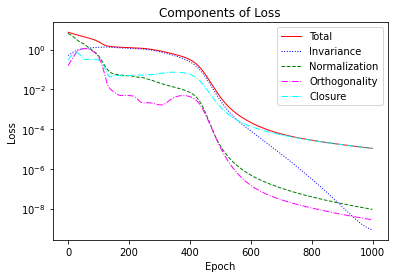

In [307]:
N=train_loss.shape[0]
plt.figure(figsize=(6,4)) #, dpi=100)
plt.plot( train_loss[:N], linewidth=1, linestyle='-',  color = 'r', label='Total')
plt.plot(comp_loss[:N,0], linewidth=1, linestyle=':',  color='b',   label='Invariance')
plt.plot(comp_loss[:N,1], linewidth=1, linestyle='--', color='g',   label='Normalization')
plt.plot(comp_loss[:N,2], linewidth=1, linestyle='-.', color='magenta', label='Orthogonality')
plt.plot(comp_loss[:N,3], linewidth=1, linestyle='-.', color='cyan', label='Closure')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Components of Loss')

plt.show()

## Extract Results

In [308]:
model.eval()

with torch.no_grad():
    struc_pred, gens_pred = model(initialize_matrices,initialize_struc_const)

# Visualize Results

## Create a Symmetry Vector Plot (for $n_{dim} = 2$)

In [309]:
if n_dim<3:
    def draw_vectors(M, oracle):
        plt.figure(figsize=(4,3.25))   #, dpi=100)

        # Makes the background contour:
        x_grid, y_grid = np.meshgrid(np.linspace(-2,2,101), np.linspace(-2,2,101))
   
        grid_points = torch.tensor(np.stack([x_grid.flatten(), y_grid.flatten()], axis=1))
        oracle_vals = oracle(grid_points).numpy().reshape(x_grid.shape)

        plt.contourf(x_grid, y_grid, oracle_vals, 32, cmap='RdBu') #, norm = mpl.colors.CenteredNorm() )

        # now make the vector field:
        # This makes the points which are the tails of the vectors
        x_grid, y_grid = np.meshgrid(np.linspace(-2,2,20), np.linspace(-2,2,20))

        # calculates the vector at each point
        x_vec_grid, y_vec_grid = np.einsum('il,ljk', M.detach().numpy(), np.stack([x_grid, y_grid]))
       
        # loops over those points and corresponding vectors and draws the arrow
        for x, y, dx, dy in zip(x_grid.flatten(),
                                y_grid.flatten(),
                                x_vec_grid.flatten(),
                                y_vec_grid.flatten()):
       
            # this is the factor by which all vectors are scaled down:
            scale=.05
            plt.arrow(x, y, dx*scale, dy*scale, head_width=.03, lw=.5, fc='k', ec='k')

        plt.xlim(-2,2)
        plt.ylim(-2,2)
        plt.yticks(np.arange(-2,3))
        plt.xlabel('$x^{(1)}$',fontsize=12)
        plt.ylabel('$x^{(2)}$',fontsize=12)
        plt.colorbar(label='$\phi(\\vec{x})$')

In [310]:
# get the matrix of the generator you want to draw:
if n_dim<3:
    M = gens_pred[0]
    # pass that matrix into the function along with the oracle function:
    draw_vectors(M, oracle = oracle)

## View the Resulting Generator(s)

Generator 1: 
 tensor([[-4.7289e-04, -8.3947e-01, -5.0914e-01],
        [ 8.3956e-01, -3.6253e-04,  1.8964e-01],
        [ 5.0900e-01, -1.9004e-01, -1.6280e-04]]) 

Generator 2: 
 tensor([[-4.5512e-04,  5.4306e-01, -7.9824e-01],
        [-5.4287e-01, -1.8588e-04,  2.6079e-01],
        [ 7.9836e-01, -2.6033e-01, -3.5481e-04]]) 

Generator 3: 
 tensor([[-7.1503e-05, -1.9059e-02, -3.2183e-01],
        [ 1.8764e-02, -4.3666e-04, -9.4663e-01],
        [ 3.2186e-01,  9.4662e-01, -4.8628e-04]]) 



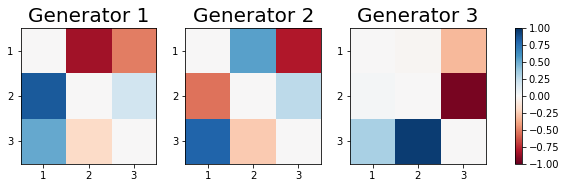

In [311]:
rows=1
cols=3
figsize=(12,2.5)

# Create labels for matrix rows and columns
ticks_gen_im =[]
ticks_gen_im_label = []
for i in range(n_dim):
    ticks_gen_im.append(i)
    ticks_gen_im_label.append(str(i+1))
    
if rows==1 and cols==1:
    fig = plt.subplots(rows,cols,figsize=figsize)
    GEN = gens_pred[0]
    plt.subplot(111)
    print(f'Generator: \n {GEN} \n')
    im = plt.imshow(GEN.detach().numpy(), cmap='RdBu', vmin=-1., vmax=1.)#norm=mpl.colors.CenteredNorm())
#     det = np.linalg.det(np.eye(GEN.shape[0]) + eps * GEN.detach().numpy())
#     ax.set_title(f'det = {det}')
#     ax.axis('off')
    plt.colorbar(im)
    
else:
    fig,axes = plt.subplots(rows,cols,figsize=figsize)
#     for i, ax_GEN in enumerate(zip(axes.flat,gens_pred)):
#         plt.subplot(rows,cols,i+1)
#         if n_gen<5:
#             print(f'Generator {i+1}: \n {ax_GEN[1]} \n')
#         im = ax_GEN[0].imshow(ax_GEN[1].detach().numpy(), cmap='RdBu', vmin=-1., vmax=1.)
#         ax_GEN[0].set_xticks(ticks=ticks_gen_im)
#         ax_GEN[0].set_xticklabels(labels=ticks_gen_im_label)
#         ax_GEN[0].set_yticks(ticks=ticks_gen_im)
#         ax_GEN[0].set_yticklabels(labels=ticks_gen_im_label)
#         ax_GEN[0].set_title('Generator '+str(i+1),fontsize=20)
    for i,GEN in enumerate(gens_pred):
        plt.subplot(rows,cols,i+1)
        if n_gen<10:
            print(f'Generator {i+1}: \n {GEN} \n')
        im = plt.imshow(GEN.detach().numpy(), cmap='RdBu', vmin=-1., vmax=1.) # use ax_GEN[0] with axes
#         if n_gen<7:
#             det = np.linalg.det(np.eye(GEN.shape[0]) + eps * GEN.detach().numpy()) #ax_GEN[1]
#             plt.title(f'det = {det}')
#         plt.axis('off')
        plt.xticks(ticks=ticks_gen_im, labels=ticks_gen_im_label)
        plt.yticks(ticks=ticks_gen_im, labels=ticks_gen_im_label)
        plt.title('Generator '+str(i+1),fontsize=20)

    plt.subplots_adjust(right=0.8)
    plt.colorbar(im, ax=axes.ravel().tolist(), ticks = [-1.0,-0.75,-0.50,-0.25,0,0.25,0.50,0.75,1.0])
#plt.savefig('Orth_gen_3_3_00.png',bbox_inches='tight')

## Visualize Rotation Axis Results for  $n_{dim} = 3$, $n_{gen} = 3$

In [312]:
# Adapted from code by Alex Roman
def draw_vec(ax, v, lw, color, label):
    # Draw a vector to ax, this adds lines for the projection
    # Draw vector (0,0,0) to (v0,v1,v2)
    ax.plot([0,   v[0]], [0,   v[1]], [0, v[2]], color=color, lw=lw, label=label)
    # Fix (x,y) and draw a line from z=0 to z=v[2] (z component of rot vec)
    # Draw vector (v0,v1,0) to (v0,v1,v2) == straight line up... etc.
    ax.plot([v[0],v[0]], [v[1],v[1]], [0,v[2]], color='b', alpha=.25, ls='--')
    # Fix (x,z) and draw a line from y=0 to y=v[1] (y component of rot vec)
    ax.plot([v[0],v[0]], [0   ,v[1]], [0,0   ], color='b', alpha=.25, ls='--')
    # Fix (y,z) and draw a line from x=0 to x=v[0] (x component of rot vec)
    ax.plot([0   ,v[0]], [v[1],v[1]], [0,0   ], color='b', alpha=.25, ls='--')
    
def get_axis_np(M):
    # Finds the eigenvector with min(Imaginary(eigenvalue))
    # if the matrix is a rotation matrix or a generator of rotations, then this vector is the axis of rotation 
    eig_vals, eig_vecs = np.linalg.eig(M)
    index = np.argmin(np.sum(np.abs(eig_vecs.T.imag),axis=1)) # T is for transpose
    # find the minimum arg of the minimum imaginary component
    # pass that to the transposed eigenvector array to pull the eigenvecto
    axis = eig_vecs.T[index].real
    # Change to more positive than negative values in axis vector by multiplying by the net sign
    return np.sign(np.sum(axis))*axis

def draw_axes(gens, verbose=True):
    G1, G2, G3 = gens
    # gather rotation axes
    axis1 = get_axis_np(G1.detach().numpy())
    axis2 = get_axis_np(G2.detach().numpy())
    axis3 = get_axis_np(G3.detach().numpy())
    
    # to be more verbose (include extra detail) list the 
    # rotation axes found from the axis function
    if verbose:
        print(f'Axis 1: {axis1}')
        print(f'Axis 2: {axis2}')
        print(f'Axis 3: {axis3}')
    
    # set up plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d')
    ax.grid(False)
    
    # draw x,y,z axes on graph
    ax_lim = 1
    ax.plot([-ax_lim,ax_lim],[0,0],[0,0], color='black', alpha=.3)
    ax.plot([0,0],[-ax_lim,ax_lim],[0,0], color='black', alpha=.3)
    ax.plot([0,0],[0,0],[-ax_lim,ax_lim], color='black', alpha=.3)

    # set bounds on graph to be +-1
    ax.set_xlim(-ax_lim,ax_lim)
    ax.set_ylim(-ax_lim,ax_lim)
    ax.set_zlim(-ax_lim,ax_lim)
    
    # draw each rotation axis
    lw = 5
    draw_vec(ax = ax, v = axis1, lw=lw, color = 'b', label='Axis '+str(1))
    draw_vec(ax = ax, v = axis2, lw=lw, color = 'r', label='Axis '+str(2))
    draw_vec(ax = ax, v = axis3, lw=lw, color = 'g', label='Axis '+str(3))
    plt.legend()
    plt.show()

Axis 1: [-0.189838 -0.509071 0.839528]
Axis 2: [0.260557 0.798310 0.542965]
Axis 3: [0.946604 -0.321844 0.018905]


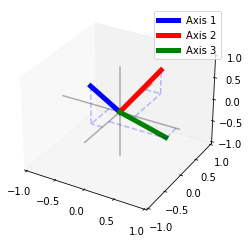

In [313]:
if len(gens_pred)==3 and n_dim==3:
    draw_axes(gens_pred)
    plt.show()

## View the Resulting Structure Constants (for $n_{gen}>1$)

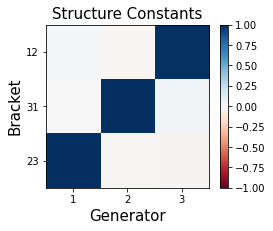

In [314]:
if n_gen>1:
    
    figsize=(4,3)
    
    if n_gen==3:
        X = torch.tensor(struc_pred.numpy())
        struc_cyclic = X
        struc_cyclic[1] = -X[1]
        
    commutator_labels = []
    if n_com==3:
        # Make the commutations cyclic for 3 generators
        for i in range(n_gen):
             for j in range(n_gen):
                    if i<j:
                        if (j-i)==2:
                            commutator_labels.append(str(j+1)+str(i+1))
                        else:
                            commutator_labels.append(str(i+1)+str(j+1))
    else:
        for i in range(n_gen):
            for j in range(n_gen):
                if i<j:
                    commutator_labels.append(str(i+1)+str(j+1))
        
    ticks_com = []
    for i in range(n_com):
        ticks_com.append(i)

    ticks_gen = []
    generator_labels = []
    for i in range(n_gen):
        ticks_gen.append(i)
        generator_labels.append(str(i+1))
    
    plt.figure(figsize=figsize)
    if n_com==3:
        plt.imshow(struc_cyclic.detach().numpy(), cmap='RdBu', vmin=-1.,vmax=1.)#norm=mpl.colors.CenteredNorm())
    else:
        plt.imshow(struc_pred.detach().numpy(), cmap='RdBu', vmin=-1.,vmax=1.)#norm=mpl.colors.CenteredNorm())
    plt.xticks(ticks=ticks_gen,labels=generator_labels)
    plt.xlabel('Generator',fontsize=15)
    plt.yticks(ticks=ticks_com,labels=commutator_labels)
    plt.ylabel('Bracket',fontsize=15)
    plt.title('Structure Constants',fontsize=15)
    plt.colorbar()
    plt.savefig('Orth_sc_3_3_00.png',bbox_inches='tight')
    
#     # add grid lines
#     for i in range(n_gen-1):
#         plt.axvline(x=1/2+i, linewidth=1, color ='black')
#     for i in range(n_com-1):
#         plt.axhline(y=1/2+i-0.01, linewidth=1, color ='black')

# Verify Results

## Verify the Structure Constants Produce an Algebra (for $n_{gen}>1$)

In [315]:
if n_gen>1:
    if n_gen==3:
        X = torch.tensor(struc_pred.numpy())
        struc_cyclic = X
        struc_cyclic[1] = -X[1]

    comm_index = 0
    Cs = []
    for i,G in enumerate(gens_pred):
        for j,H in enumerate(gens_pred):
            if i<j and n_gen!=3:
                C1 = bracket(G,H)
                C2 = 0
                for k,K in enumerate(gens_pred):
                    C2 += struc_pred[comm_index,k]*K
                C = C1 - C2
                error = torch.mean(torch.abs(C.real))
                print(str(i+1)+str(j+1)+': \n Structure Constants = '+str(struc_pred[comm_index,:].detach().numpy())+'\n \n C = \n ',C.detach().numpy(),'\n')
                if error<1e-1:
                    print(f'The structure constants were found successfully with a mean absolute error (MAE) of {error}. \n \n')
                elif error>1e-1:
                    print(f'The structure constants were NOT found successfully with a mean absolute error (MAE) of {error}. \n \n')
                Cs.append(C)
                comm_index+=1
            # Make the cyclic commutators if n_gen = 3   
            elif i<j and n_gen==3:
                if (j-i)==2:
                    C1 = bracket(H,G)
                    C2 = 0
                    for k,K in enumerate(gens_pred):
                        C2 += struc_cyclic[comm_index,k]*K
                    C = C1 - C2
                    error = torch.mean(torch.abs(C.real))
                    print(str(j+1)+str(i+1)+': \n Structure Constants = '+str(struc_cyclic[comm_index,:].detach().numpy())+'\n \n C = \n ',C.detach().numpy(),'\n')
                    if error<1e-1:
                        print(f'The structure constants were found successfully with a mean absolute error (MAE) of {error}. \n \n')
                    elif error>1e-1:
                        print(f'The structure constants were NOT found successfully with a mean absolute error (MAE) of {error}. \n \n') 
                    Cs.append(C)
                    comm_index+=1
                else:
                    C1 = bracket(G,H)
                    C2 = 0
                    for k,K in enumerate(gens_pred):
                        C2 += struc_cyclic[comm_index,k]*K
                    C = C1 - C2
                    error = torch.mean(torch.abs(C.real))
                    print(str(i+1)+str(j+1)+': \n Structure Constants = '+str(struc_cyclic[comm_index,:].detach().numpy())+'\n \n C = \n ',C.detach().numpy(),'\n')
                    if error<1e-1:
                        print(f'The structure constants were found successfully with a mean absolute error (MAE) of {error}. \n \n')
                    elif error>1e-1:
                        print(f'The structure constants were NOT found successfully with a mean absolute error (MAE) of {error}. \n \n') 
                    Cs.append(C)
                    comm_index+=1
    
    
    # Calculate the total MSE in finding the structure constants
    tot_error = 0.
    for i,C in enumerate(Cs):
        tot_error+=torch.mean(torch.abs(C.real))
    print(f'Total MAE = {tot_error}')
    # if error < 1e-1:
    #     print(f'The structure constants were found successfully with a mean absolute error (MAE) of {error}.')
    # else:
    #     print(f'The structure constants were NOT found successfully with a mean absolute error (MAE) of {error}.')

12: 
 Structure Constants = [0.017815 -0.023160 0.984890]
 
 C = 
  [[-0.000317 0.026862 -0.014158]
 [-0.027634 0.000832 -0.011666]
 [0.014358 0.011576 0.000459]] 

The structure constants were found successfully with a mean absolute error (MAE) of 0.011984755043286244. 
 

31: 
 Structure Constants = [-0.003899 1.009901 0.025461]
 
 C = 
  [[0.000270 -0.008417 0.013760]
 [0.007870 0.000831 0.021938]
 [-0.014479 -0.022601 -0.000074]] 

The structure constants were found successfully with a mean absolute error (MAE) of 0.010026740119474126. 
 

23: 
 Structure Constants = [1.017229 -0.007850 -0.024331]
 
 C = 
  [[0.000338 0.018127 -0.004934]
 [-0.018334 0.000939 -0.024371]
 [0.005708 0.024127 -0.000293]] 

The structure constants were found successfully with a mean absolute error (MAE) of 0.010796919305456357. 
 

Total MAE = 0.03280841446821672


## Verify Orthogonality (for $n_{gen}>1$)

In [316]:
def get_angle(v, w):
    # Angle between vectors
    return v @ w / (torch.norm(v) * torch.norm(w))

def get_axis(M):
    # Finds the eigenvector with min(Imaginary(eigenvalue))
    # if the matrix is a rotation matrix or a generator of rotation,s then this vector is the axis of rotation  
    eig_vals, eig_vecs = torch.linalg.eig(M)
    # find the minimum arg of the minimum imaginary component
    # pass that to the transposed eigenvector array to pull the eigenvector
    axis = eig_vecs.T[torch.argmin(torch.abs(eig_vals.imag))]
    # Change to more positive than negative values in axis vector by multiplying by the net sign
    return torch.sign(torch.sum(axis).real)*axis

In [317]:
for i,G in enumerate(gens_pred):
    for j,H in enumerate(gens_pred):
        if i<j:
            angle = get_angle(get_axis(G).real, get_axis(H).real)
            angle_deg = 180/np.pi*np.arccos(float(get_angle(get_axis(G).real, get_axis(H).real)))
            print(f'Angle between generator {i+1} and {j+1}: {angle:>.10f} rad, {angle_deg:>.10f} deg')

Angle between generator 1 and 2: -0.0000264038 rad, 90.0015128290 deg
Angle between generator 1 and 3: 0.0000114697 rad, 89.9993428343 deg
Angle between generator 2 and 3: -0.0000225576 rad, 90.0012924545 deg
